## Access to historical data from the World Database on Protected Areas (WDPA) and harmonization
This block is dedicated to refining initial land-use/land-cover (LULC) data with additional data on protected areas (PA) from [the World Database on Protected Areas (WDPA)](https://www.protectedplanet.net/en/thematic-areas/wdpa).
As soon as protected areas may significantly increase the suitability of landscapes and reduce landscape "impedance" for species migration, landscapes intersected with PAs should be considered different from those without protected status. This workflow describes the enrichment of LULC data needed to compute functional landscape connectivity. It provides two main outputs:
- LULC data enriched with protected areas (recorded as updated LULC value) for wide usage.
- For habitat connectivity calculations, impedance and affinity values to compute follow-up indicators in specific software (for example,MiraMon and Graphab).

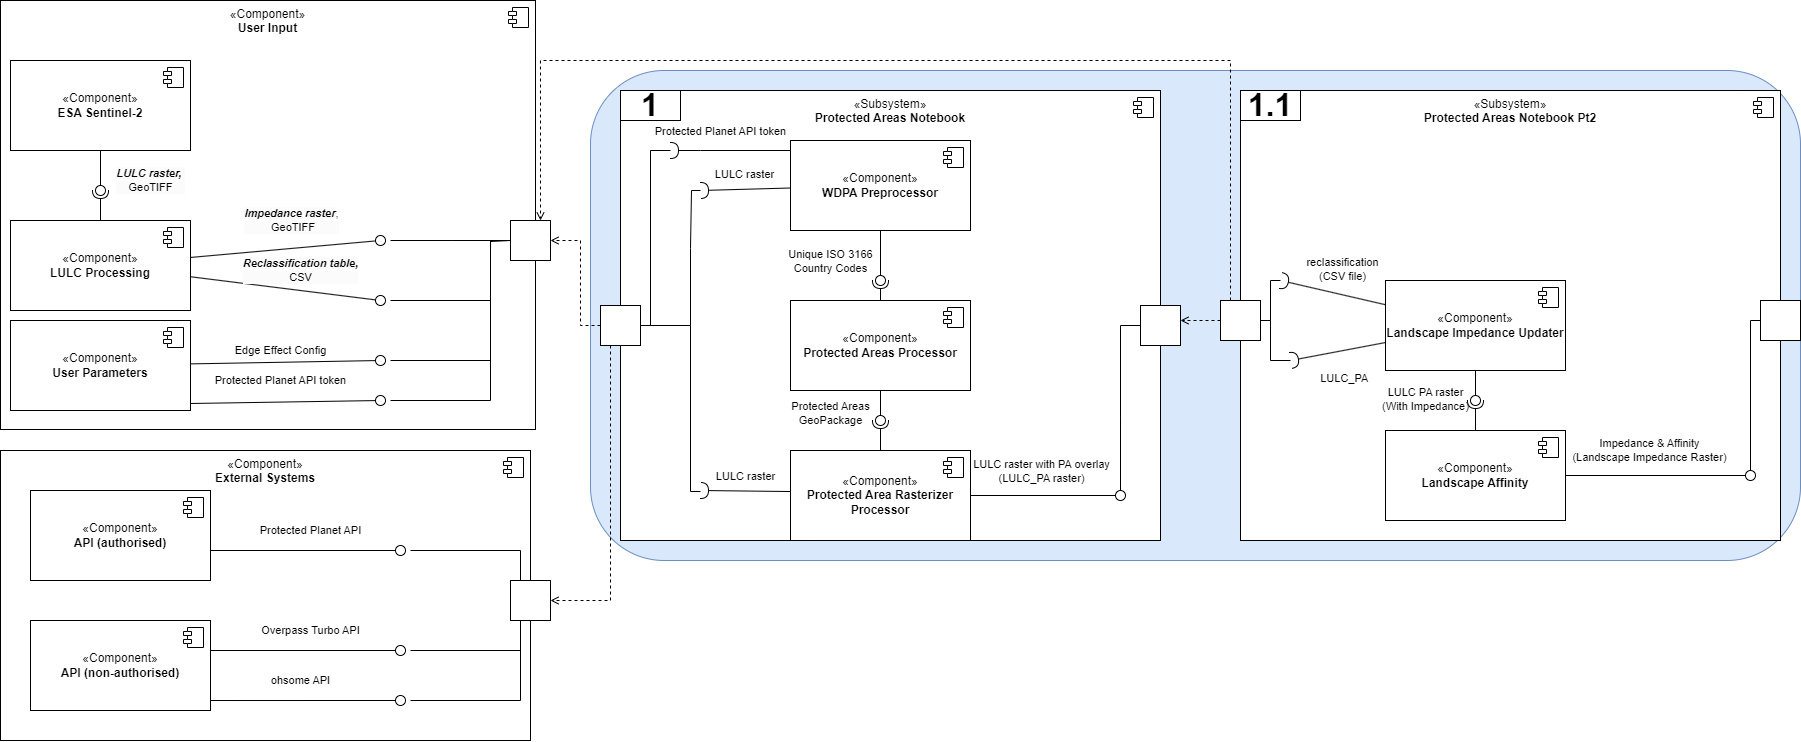

**WARNING**: this block is available only if users are authorised at Protected Planet API and have been granted with a [personal token](https://api.protectedplanet.net/request).

### Current limitations:
- Protected Planet API is accessed through personal credentials, while granting access to the API is not automatic and reviewed by the Protected Planet team.
- Protected Planet API does not support getting data by bounding box, only by unique IDs of protected areas and countries.
- Protected Planet API might provide a warning if user fetches the protected areas for the United Kingdom (*"Several features with id = 959 have been found. Altering it to be unique. This warning will not be emitted anymore for this layer"*).
- Temporary server outage has been experienced with Protected Planet API (returning 'status code 500'), as well as occasional error 521.
- If a protected area is deestablished ('degazetted'), it is removed from the database and its ID cannot be reused (for further details, see the [manual on Protected Planet API](https://wdpa.s3-eu-west-1.amazonaws.com/WDPA_Manual/English/WDPA_WDOECM_Manual_1_6.pdf)). If it is the case, all historical transformations of these protected areas will be not accessible to request.
- [Overpass API](https://wiki.openstreetmap.org/wiki/Overpass_API) is used as an ancillary tool to perform reverse geocoding and find countries intersecting with the input raster dataset to query for data through Protected Planet API. At the same time, boundaries of countries include the exclusive economic zones in seas and can cover not only terrestrial protected areas.
- [Overpass API](https://wiki.openstreetmap.org/wiki/Overpass_API) does not fetch countries if bounding box of input raster dataset is within the spatial feature (country), but does not intersect with her borderline.


#### 1. Fetching data through Protected Planet API

Spatial data on protected areas in GeoJSON and GeoPackage formats for countries needed (on our case, Spain, France and Andorra) are obtained through WDPA API using a personal access token and [official docimentation](https://api.protectedplanet.net/documentation). Most meaningful attributes have been chosen (IDs, designation status, IUCN category, year of establishment etc.)

Let's import libraries neeeded. We need to specify the working directory at one level above as this Jupyter Notebook is located in a subrepository of tool.

In [ ]:
import requests
from shapely.geometry import shape
import json
import subprocess
import os
import sys
from datetime import datetime
from itertools import product
import warnings
import timing

# define own modules from the root directory (at level above)
# define current directory (This is the working directory in the docker container, which is src)
current_dir = os.getcwd()
print(current_dir)

# define child pa directory (level below)
pa_dir = os.path.abspath(os.path.join(current_dir, '1_protected_areas'))
# add the parent directory to sys.path
sys.path.append(current_dir)

timing.start()

We are also loading the configuration file from local import. Input variables are stored in this configuration file (eg input raster dataset, timestamp).

In [ ]:
# local import
from utils import load_yaml

from reprojection import RasterTransform

#### Reverse geocoding
To use Protected Planet API it is requred to list countries for query on protected areas. Currently this is implemented through ohsome API fetching codes of countries (according to [ISO 3166-1 alpha-3](https://www.iso.org/iso-3166-country-codes.html)  standard).
Other ways attempted:
- [Nominatim API](https://nominatim.org/release-docs/latest/api/Overview/) is unstable when quering with multiple filters to fetch the borderlines from the Open Street Map portal (does not bring features needed).
- [Overpass API](https://wiki.openstreetmap.org/wiki/Overpass_API) fetches features only if they intersect with the bounding box, but does not supply with countries if the bounding box is located within one country and does not intersect its boundaries.
- [geopandas built-in dataset from the Natural Earth](https://www.naturalearthdata.com/downloads/50m-cultural-vectors/50m-admin-0-countries-2/), but the dataset with the boundaries of countries is not curently available there.

In [ ]:
class WDPA_PreProcessor():
    """
    This class is responsible for preprocessing the input data for the ingesting protected areas data from WDPA API.
    The input LULC raster bounding box is extracted and used to fetch the unique ISO 3166-1 alpha-3 country code from the ohsome API.
    """

    def __init__(self, config_path:str) -> None:
        """
        Initialize the WDPA_PreProcessor class

        Args:
            config_path (str): path to the configuration file
        """
        self.config = load_yaml(config_path)

        # read year 
        self.years = self.config.get('year', None)
        if self.years is None:
            warnings.warn("Year variable is null or not found in the configuration file.")
            self.years = []
        elif isinstance(self.years, int):
            self.years = [self.years]
        else:
            # cast to list
            self.years = [int(year) for year in self.years]

        #read lulc
        self.lulc_templates = self.config.get('lulc', None)
        if self.lulc_templates is None:
            raise ValueError("LULC variable is null or not found in the configuration file.")
        elif isinstance(self.lulc_templates, str):
            self.lulc_templates = [self.lulc_templates]
        else:
            # cast to list
            self.lulc_templates = [lulc for lulc in self.lulc_templates]

        # read lulc_dir
        self.lulc_dir = self.config.get('lulc_dir', None)
        if self.lulc_dir is None:
            raise ValueError("LULC directory is null or not found in the configuration file.")

        # get all existing files
        self.lulc_series = self.get_all_existing_files(self.lulc_templates, self.years)

    def get_all_existing_files(self, lulc_templates: list, years: list) -> list[str]:
        """
        Get all existing files based on the list of years and the LULC templates

        Args:
            lulc_templates (list): list of LULC templates (e.g. ['lulc_{year}.tif', 'lulc_{year}_v2.tif'])
            years (list): list of years (e.g. [2015, 2016, 2017])
        Returns:
            list: list of existing files to process (e.g. ['lulc_2015.tif', 'lulc_2016.tif'])
        """

        # generate all possible filenames based on the list of years
        lulc_series = []
        # use itertools,product to create combination of lulc filename and year
        for lulc_template, year in product(lulc_templates, years): 
            try:
                # substitute year in the template
                lulc_file = lulc_template.format(year=year)
                # construct the full path to the input raster dataset
                lulc_path = os.path.join(current_dir, self.lulc_dir, lulc_file)
                # mormalize the path to ensure it is correctly formatted
                lulc_path = os.path.normpath(lulc_path)
                lulc_series.append(lulc_path)
            except KeyError as e:
                raise ValueError(f"Placeholder {e.args[0]} not found in 'lulc_template'") from e
            
        # Check if files exist and collect existing files
        existing_lulc_series = []
        for lulc_templates in lulc_series:
            if os.path.exists(lulc_templates):
                print(f"Input raster to be used for processing is {lulc_templates}")
                existing_lulc_series.append(lulc_templates)
            else:
                print(f"File does not exist: {lulc_templates}")

        # list all existing filenames to process
        print("\nList of available input raster datasets to process:")
        for lulc_templates in existing_lulc_series:
            print(f"Processing file: {lulc_templates}")

        # update lulc_series with files that exist
        return existing_lulc_series
        
    #NOTE Ohsome API is using openstreetmap data, which may not be the best source to fetch country codes from bounding box with. The GAUL dataset provided by FAO (UN) is a better source for this but it is not available through API.
    def get_country_code_from_bbox(self, bbox:str, save_geojson:bool=True) -> set:
        """
        This function sends a request to the ohsome API to get the country code from a given bounding box

        Args:
            bbox (str): bounding box in the format 'x_min,y_min,x_max,y_max'
            save_geojson (bool): save the geojson file (default is True)

        Returns:
            set: set of unique country codes
        """
        url = 'https://api.ohsome.org/v1/elements/geometry'
        data = {"bboxes": {bbox}, "filter": "boundary=administrative and admin_level=2", "properties": 'tags'}
        response = requests.post(url, data=data)

        # check if the request was successful
        if response.status_code == 200:
            response_json = response.json()
            print("Request was successful")
            # extract unique country names, filtering out None values
            # create set to handle only unique names
            unique_country_names = {
                feature['properties'].get('ISO3166-1:alpha3') 
                for feature in response_json.get('features', []) # filter out none values
                if feature['properties'].get('ISO3166-1:alpha3')
            }
    
            # print unique country names
            print(f"Countries covered by the bounding box are (ISO-3 codes): \n{'\n'.join(unique_country_names)}")
            print("-" * 40)

            # save JSON response to GeoJSON
            if save_geojson:
                with open('countries.geojson', 'w') as f:
                    json.dump(response_json, f, indent=4)
        else:
            print(f"Error: {response.status_code}")
            print("-" * 40)

        return unique_country_names
        
    def fetch_lulc_country_codes(self, save_geojson:bool=True) -> dict[set]:
        """
        Fetch the country codes for the LULC rasters

        Args:
            save_geojson (bool): save the geojson file (default is True)

        Returns:
            dict: dictionary containing the country codes for each LULC raster
        """
        lulc_country_codes = {}
        for lulc in self.lulc_series:
            x_min, y_min, x_max, y_max = RasterTransform(lulc).bbox_to_WGS84()
            bbox = f"{x_min},{y_min},{x_max},{y_max}"
            lulc_country_codes[lulc] = self.get_country_code_from_bbox(bbox, save_geojson)
        return lulc_country_codes

In [ ]:
wdpa_preprocessor = WDPA_PreProcessor(os.path.join(current_dir, 'config.yaml'))
config = wdpa_preprocessor.config
lulc_country_codes = wdpa_preprocessor.fetch_lulc_country_codes()

#get all the values of the dictionary as a set of unique country codes
unique_country_names = set().union(*lulc_country_codes.values())

#### Looping over countries from the bounding box

Now, we can loop over the countries of the bounding box of input raster dataset, fetch json response and convert them into GeoJSON format.

In [ ]:
class PA_Processor:
    """
    This protected area (PA) processor class is used to convert the json responses from the Protected Planet API to a single GeoJSON file per country.
    """
    def __init__(self, country:str) -> None:
        """
        Initialize the PA_Processor class

        Args:
            country (str): The country name.
        """
        self.country = country
        self.feature_collection = {
            "type": "FeatureCollection",
            "features": []
        }

    def add_PA_to_feature_collection(self, protected_areas:list[dict], exclude_redundant_ids:bool=True) -> dict:
        """
        Adds protected areas from the API response to the feature collection of the class.

        Args:
            protected_areas (list): A list of protected areas dictionaries.

        Returns:
            feature_collection: The feature collection with protected areas.
        """

        # Ccunter for geometry print statements
        print_count = 0
        max_prints = 10
        
        # loop over protected areas        
        for pa in protected_areas:

            # convert date string to datetime object
            date_str = pa['legal_status_updated_at']

            # filter out protected areas if no date of establishment year is recorded
            if date_str is None:
                continue
            # format to YYYY-MM-DD
            else:
                try:
                    date = datetime.strptime(date_str, '%Y-%m-%d')
                except ValueError:
                    # handle cases where the date is in a different format
                    try:
                        date = datetime.strptime(date_str, '%d/%m/%Y')
                    except ValueError:
                        # handle cases where the date is in a different format
                        date = datetime.strptime(date_str, '%m/%d/%Y')
                    
                # format to YYYY-MM-DD
                date_str = date.strftime('%Y-%m-%d')
              
            # extract geometry
            geometry = pa['geojson']['geometry']
            pa.get('geojson', {}).get('geometry')

            # debugging, print the geometry data
            if geometry is None:
                print(f"Warning: No geometry found for protected area {pa.get('name')} with ID {pa.get('id')}")
            elif print_count < max_prints:
                print(f"Geometry found for protected area {pa.get('name')} with ID {pa.get('id')}")
                print_count += 1
            if print_count == max_prints:
                print("More than 10 geometries found for protected areas...")
                print_count += 1  # prevent repeated summary messages

            if exclude_redundant_ids:
                pa['designation'].pop('id', None)
                pa['designation']['jurisdiction'] = pa['designation']['jurisdiction']["name"]
                pa['iucn_category'] = pa['iucn_category']['name']
                pa['legal_status'] = pa['legal_status']['name']
               

            # create feature with geometry and properties
            feature = {
                "type": "Feature",
                "geometry": geometry,
                "properties": {
                    "id": pa['id'],
                    "name": pa['name'],
                    "original_name": pa['name'],
                    "wdpa_id": pa['id'],
                    "management_plan": pa['management_plan'],
                    "is_green_list": pa['is_green_list'],
                    "iucn_category": pa['iucn_category'],
                    "designation": pa['designation'],
                    "legal_status": pa['legal_status'],
                    "year": date_str,
                }
            }
            # append the feature to the feature collection
            self.feature_collection["features"].append(feature) 

        return self.feature_collection

    def save_to_file(self, file_path:str) -> str:
        """
        Saves a country feature collection to a single GeoJSON file.

        Args:
            file_path (str): The path to the file.

        Returns:
            geojson_filepath (str): The path to the saved GeoJSON file.
        """
        # define filename for GeoJSON file
        geojson_filepath = os.path.join(file_path, f"{self.country}_protected_areas.geojson")
        # convert GeoJSON data to a string
        geojson_string = json.dumps(self.feature_collection, indent=4) 
        # write GeoJSON string to a file
        with open(geojson_filepath, 'w') as f:
            f.write(geojson_string)
        
        return geojson_filepath

In [ ]:
class PA_Processor_Wrapper:
    """
    This class retrieves and processes protected areas for multiple countries and utilizes the PA processor class to merge them into individual GeoJSON files for each country.
    """

    def __init__(self, countries:list[str], api_url:str, token:str, marine:str, output_dir:str) -> None:
        """
        Initialize the PA_Processor_Wrapper class.

        Args:
            countries (list): A list of country codes.
            api_url (str): The API endpoint URL.
            token (str): The API token.
            marine (str): The marine area boolean value.
            output_dir (str): The path to the directory where the GeoJSON files will be saved.
        """
        self.api_url = api_url
        self.token = token
        self.marine = marine
        self.countries = countries
        self.output_dir = output_dir
        self.processors = {country: PA_Processor(country) for country in countries}

    def process_all_countries(self) -> None:
        """
        Fetches all PAs for each country and processes them into a single GeoJSON file.
        """

        for country in self.countries:
            all_protected_area_geojson = []
            page = 0
            url = self.api_url.format(country=country, token=self.token, marine=self.marine)
            while True:
                url += f"&page={page}"
                response = requests.get(url)
                if response.status_code != 200:
                    print(f"Error: {response.status_code}")
                    break
                data = response.json()
                protected_areas = data["protected_areas"]
                if len(protected_areas) == 0:
                    break
                else:
                    all_protected_area_geojson.append(data)
                    page += 1

            # combine all the protected areas into a single feature collection / GeoJSON
            for data in all_protected_area_geojson:
                self.processors[country].add_PA_to_feature_collection(data["protected_areas"]) 

    def save_all_country_geoJSON(self) -> list[str]:
        """
        Saves all country GeoJSON files to the export directory.

        Returns:
            geojson_filepaths (list): A list of file paths to the saved GeoJSON files.
        """
        
        geojson_filepaths = []
        for country in self.countries:
            geojson_filepaths.append(self.processors[country].save_to_file(self.output_dir))
        return geojson_filepaths
    

    def export_all_to_geopackage(self, geojson_filepaths:list[str], output_file:str = "merged_protected_areas.gpkg") -> str:
        """
        Merges all GeoJSON files into a single GeoPackage file with different layers for each country.

        Args:
            geojson_filepaths (list): A list of GeoJSON file paths.
            output_file (str): The name of the output GeoPackage file.
        
        Returns:
            str: The path to the merged GeoPackage file.
        """
        # define the output merged GeoPackage file
        gpkg = os.path.join(self.output_dir, output_file)
        # remove GeoPackage if it already exists
        if os.path.exists(gpkg):
            os.remove(gpkg)

       # loop through the GeoJSON files and convert them to a geopackage
        for geojson_file in geojson_filepaths:
            # writes layer name as the first name from geojson files
            layer_name = os.path.splitext(os.path.basename(geojson_file))[0]
            # use ogr2ogr to convert GeoJSON to GeoPackage
            subprocess.run([
                "ogr2ogr", "-f", "GPKG", "-append", "-nln", layer_name, gpkg, geojson_file
            ]) 

        return gpkg

Let's access Protected Planet API through an endpoint customised by the parameters from the configuration file and fetch geometries of protected areas within the countries covered by the bounding box of input raster dataset. **To access it, user should paste their Protected Planet API token obtained in advance:**

In [ ]:
# define token - replace by own
token = config.get('token')

In [ ]:
# getting variables from the configuration file
marine = config.get('marine') # fetch boolean value (false or true)

# define the API endpoint - include filter by country, marine areas, maximum values of protected areas per page (50)
api_url = "https://api.protectedplanet.net/v3/protected_areas/search?token={token}&country={country}&marine={marine}&with_geometry=true&per_page=50"
# define country codes from the previous block
countries = unique_country_names

# TODO remove API response in final versions
# directory to save GeoJSON files
response_dir = os.path.join(pa_dir, "response")
os.makedirs(response_dir, exist_ok=True)
# list to store the names of the GeoJSON files
geojson_filepaths = []

Pa_processor = PA_Processor_Wrapper(countries, api_url, token, marine, response_dir)
Pa_processor.process_all_countries()
geojson_filepaths = Pa_processor.save_all_country_geoJSON()
print(geojson_filepaths)

# exporting to geoPackage
output_file = "merged_protected_areas.gpkg"
gpkg = Pa_processor.export_all_to_geopackage(geojson_filepaths, output_file)
print(f"GeoPackage file created: {gpkg}")

#### 2. Processing of protected areas

Data downloaded from WDPA as a geopackage are processed in 4 steps:
1. Extract extent and spatial resolution of LULC data.
Redefine no data values as 0 for input LULC data.
2. Extract protected areas filtered by LULC timestamp and year of PAs establishment.
3. Rasterize protected areas (there is no way to read geodataframes by gdal_rasterize except from writing files on the disc) based on step 1.
4. Compress protected areas.

In [ ]:
import geopandas as gpd
import rasterio
import os
import subprocess
import numpy as np
from raster_metadata import RasterMetadata

class PA_Rasterizer_Processor:
    """
    This class is responsible for filtering protected areas based on the year of establishment and rasterizing them.
    """

    def __init__(self, gpkg_filepath:str, input_dir:str,output_dir:str) -> None:
        """
        Initialize the PA_Rasterizer_Processor class.

        Args:
            gpkg_filepath (str): The path to the GeoPackage file containing all the protected areas.
            input_dir (str): The path to the directory containing the LULC files.
            output_dir (str): The path to the output directory.
        """
        self.gdf = gpd.read_file(gpkg_filepath)
        self.input_folder = input_dir
        self.output_dir = output_dir
        # create output directory if it does not exist
        os.makedirs(output_dir, exist_ok=True)

        # Extract raster metadata
        tiff_files = [f for f in os.listdir(input_dir) if f.endswith('.tif')]
        if tiff_files:
            # choose the first TIFF file (it shouldn't matter which LULC file to extract extent because they must have the same extent)
            file_path = os.path.join(input_dir, tiff_files[0])  
            self.lulc_metadata = RasterMetadata.from_raster(raster_path=file_path)
            print(self.lulc_metadata)
 
        else:
            raise ValueError("No LULC files found in the input folder.")

        # extract the year from the filename (last block before the file extension with '-' separator
        self.year_stamps = [f.split('_')[-1].split('.')[0] for f in tiff_files]
        print("Considered timestamps of LULC data are:","".join(str(self.year_stamps)))
            
    def filter_pa_by_year(self, target_crs:str) -> None:
        """
        Generates subsets of protected areas based on the year of establishment, and reprojects them to the CRS of the input raster dataset.
        """
        # create an empty dictionary to store subsets
        subsets_dict = {}
        # loop through each year_stamp and create subsets
        for year_stamp in self.year_stamps:
            # filter Geodataframe based on the year_stamp
            subset = self.gdf[self.gdf['year'] <= np.datetime64(str(year_stamp))]

            # store subset in the dictionary with year_stamp as key
            subsets_dict[year_stamp] = subset

            # print key-value pairs of subsets 
            print(f"Protected areas are filtered according to year stamps of LULC and PAs' establishment year: {year_stamp}")

            # reproject geodataframe to the CRS of input rastser dataset
            subset = subset.to_crs(target_crs)

            # ADDITIONAL BLOCK IF EXPORT TO GEOPACKAGE IS NEEDED (currently needed as rasterizing vector data is not possible with geodataframes)
            ## save filtered subset to a new GeoPackage
            subset.to_file(os.path.join(self.output_dir,f"pas_{year_stamp}.gpkg"), driver='GPKG')
            print(f"Filtered protected areas are written to:",os.path.join(self.output_dir,f"pas_{year_stamp}.gpkg"))

        print ("---------------------------")
        
    def rasterize_pas_by_year(self, lulc_metadata:RasterMetadata, keep_intermediate_gpkg:bool=False) -> None:
        # list all subsets of protected areas by the year of establishment
        pas_yearstamps = [f for f in os.listdir(self.output_dir) if f.endswith('.gpkg')]
        pas_yearstamp_rasters = [f.replace('.gpkg', '.tif') for f in pas_yearstamps]

        # loop through each input file
        for pas_yearstamp, pas_yearstamp_raster in zip(pas_yearstamps, pas_yearstamp_rasters):
            pas_yearstamp_path = os.path.join(self.output_dir, pas_yearstamp)
            pas_yearstamp_raster_path = os.path.join(self.output_dir, pas_yearstamp_raster)
            # TODO - to make paths more clear and straightforward
            print(f"Rasterizing protected areas for {pas_yearstamp}")
            # rasterize
            epsg = "EPSG:" + str(lulc_metadata.crs_info['epsg'])
            pas_rasterize = [
                "gdal_rasterize",
                ##"-l", "pas__merged", if you need to specify the layer
                "-burn", "100", ## assign code starting from "100" to all LULC types
                "-init", "0",
                "-tr", str(abs(lulc_metadata.xres)), str(abs(lulc_metadata.yres)), #spatial res from LULC data (use absolute values to avoid negative res)
                "-a_srs", epsg, #output crs from LULC data
                "-a_nodata", "-2147483647", # !DO NOT ASSIGN 0 values with non-data values as it will mask them out in raster calculator
                "-te", str(lulc_metadata.x_min), str(lulc_metadata.y_min), str(lulc_metadata.x_max), str(lulc_metadata.y_max), # minimum x, minimum y, maximum x, maximum y coordinates of LULC raster
                "-ot", "Int32",
                "-of", "GTiff",
                "-co", "COMPRESS=LZW",
                pas_yearstamp_path,
                pas_yearstamp_raster_path
                ]

            print(pas_rasterize)

            # execute rasterize command
            try:
                subprocess.run(pas_rasterize, check=True)
                print("Rasterizing of protected areas has been successfully completed for", pas_yearstamp)
            except subprocess.CalledProcessError as e:
                print(f"Error rasterizing protected areas: {e}")
            finally:
                if not keep_intermediate_gpkg:
                    os.remove(pas_yearstamp_path)
                    print(f"Intermediate GeoPackage {pas_yearstamp} has been removed.")

It is important to extract year stamps from the filenames. \
**WARNING:** The name of your input dataset must always end up with four-digit year before the file extension!

Then, extent of LULC files (minimum and maximum coordinates) is extracted.

Protected areas should be filtered by year stamp according to the PA's establishment year.

Rasterization function based on yearstamps of protected areas is launched.

In [ ]:
#TODO remove this in final versions
response_dir = os.path.join(pa_dir, "response")
os.makedirs(response_dir, exist_ok=True)
gpkg = os.path.join(response_dir, "merged_protected_areas.gpkg")
rp = PA_Rasterizer_Processor(gpkg, os.path.join(current_dir,config.get("lulc_dir")),os.path.join(pa_dir,"pas_timeseries"))
rp.filter_pa_by_year(rp.lulc_metadata.crs_info["epsg"])
rp.rasterize_pas_by_year(rp.lulc_metadata, keep_intermediate_gpkg=False) 
print("Rasterizing of protected areas has been successfully completed for all years")

#### 3. Raster recalculation

LULC [enriched](/raster_sum_loop.sh) through the raster calculator (currently, external shell script):
1. Rearranging no data values as they must be considered as 0 to run raster calcualtions.
2. To sum initial LULC raster and protected areas (according to the timestamp).
3. Writing the new updated LULC map with the doubled amount of LULC codes for each timestamp (loop based on year matching in filenames).
4. Compression and assignment of null values.

In [ ]:
# call raster_sum_loop.sh using wrapped subprocess.run
import os
import sys
import subprocess
from subprocess import PIPE, Popen

def convert_to_unix_format(path_to_script: str) -> None:
    """
    Convert a shell script to Unix format using dos2unix.

    Args:
        path_to_script (str): The path to the shell script.
    """
    print("Converting shell script to Unix format...")
    try:
        subprocess.run(["dos2unix", path_to_script], check=True, text=True, capture_output=True)
        print("Conversion to Unix format completed.")
    except subprocess.CalledProcessError as e:
        print(f"Failed to convert script to Unix format: {e.stderr}")
        raise

def run_shell_command(path_to_script: str) -> None:
    """
    Run a shell script command using subprocess.run.

    Args:
        path_to_script (str): The path to the shell script.
    """
    # before executing the shell script, convert it to Unix format
    convert_to_unix_format(path_to_script)
    print("Shell script executing...")
    try:
        # Run the shell script using subprocess.run
        result = subprocess.run(
            ["bash", path_to_script],  # Pass the command as a list
            text=True,  # Ensure text output, not bytes
            capture_output=True,  # Capture stdout and stderr
            check=True  # Raise exception if the script fails
        )
        print("Shell script executed successfully!")
        print(result.stdout)
        print(result.stderr)

    except subprocess.CalledProcessError as e:
        print(f"Error executing script: {e.stderr}")
        print(result.stdout)

'''
# Change directory to '1_protected_areas' if not already there
if not os.getcwd().endswith("1_protected_areas"):
    os.chdir('./1_protected_areas')
'''

# Define the current and parent directories
current_dir = os.getcwd()
print(f"Current directory: {current_dir}")
sys.path.append(current_dir)

# Call the shell script
try:
    run_shell_command('raster_sum_loop.sh')
except Exception as e:
    print(f"Script failed with error: {e}")

#### 4. Updating landscape impedance
Impedance is reclassified by [CSV table](/reclassification.csv) and compressed (through LZW compression, not Cloud Optimised Geotiff standard to avoid any further issues in processing). Landscape impedance is required by Miramon ICT and Graphab tools both.

Let's import another set of libraries needed and define the class to update the impedance.

In [ ]:
from osgeo import gdal
gdal.UseExceptions()
import numpy as np
import csv
import os
import subprocess
import pandas as pd

class Update_land_impedance():
    """
    This class is responsible for updating the impedance dataset based on the reclassification table or the multiplier effect of protected areas.
    """

    def __init__(self, config) -> None:
        """
        Initialize the Update_land_impedance class.

        Args:
            config (dict): The configuration dictionary.
        """
        self.config = config

        # read input folder for LULC data
        self.input_folder = self.config.get('lulc_dir', None)
        if self.input_folder is None:
            raise ValueError("LULC directory is null or not found in the configuration file.")

        # read impedance_dir as the output folder
        self.output_folder = self.config.get('impedance_dir', None)
        if self.output_folder is None:
            raise ValueError("Impedance directory is null or not found in the configuration file.")

        # read flag on reclassification table (lulc-impedance) from configuration file (true or false)
        self.lulc_reclass_table = self.config.get('lulc_reclass_table', None)
        if self.lulc_reclass_table is None:
            warnings.warn("Flag on the usage of reclassification table is not found.")

        # read reclassification table (impedance) file with the reclassification table
        self.reclass_table = self.config.get('impedance', None)
        if self.reclass_table is None:
            raise ValueError("File with reclassification table for impedance is null or not found in the configuration file.")

        # read effect of protected areas (positive effect of protected areas on landscape impedance)
        self.pa_effect = self.config.get('pa_effect', None)
        if self.reclass_table is None:
            warnings.warn("Effect of protected areas (multiplier) to refine landscape impedance is null or not found in the configuration file. If you do not specify the effect please ensure the compatibility of your reclassification table.")
        

        os.makedirs(self.output_folder, exist_ok=True)
        
        self.tiff_files = [f for f in os.listdir(self.input_folder) if f.endswith('_pa.tif')] # ADDED SUFFIX (UPDATED LULC)
        self.impedance_files = [f for f in os.listdir(self.output_folder) if f.endswith('.tif')] # IMPEDANCE DATASET


    def update_impedance(self, impedance_dir:str) -> None:
        """
        Updates the impedance dataset based on the reclassification table or the multiplier effect of protected areas.

        Args:
            impedance_dir (str): The path to the impedance directory (where the reclassification table is stored).
        """
        # intialise the path variable to the reclassification table
        path_to_reclass_table = os.path.join(impedance_dir, self.reclass_table)
         # 1. If user wants to use reclassification table to update impedance dataset
        if self.lulc_reclass_table is True:
            print ("Impedance dataset is being updated by the reclassification table...")
            for tiff_file in self.tiff_files:
                input_raster_path = os.path.join(self.input_folder, tiff_file)
                print (tiff_file)
                # modify the output raster filename to ensure it's different from the input raster filename
                output_filename = "impedance_" + tiff_file
                output_raster_path = os.path.join(self.output_folder, output_filename)

                # call function and capture data_type for compression - Float32 or Int32
                data_type = self.reclassify_raster(input_raster_path, output_raster_path, path_to_reclass_table)
                print ("Data type used to reclassify LULC as impedance is",data_type)

                # compression using 9999 as nodata
                compressed_raster_path = os.path.splitext(output_raster_path)[0] + '_compr.tif'
                print("Path to compressed raster is:", compressed_raster_path)
                subprocess.run(['gdal_translate', output_raster_path, compressed_raster_path,'-a_nodata', '9999', '-ot', data_type, '-co', 'COMPRESS=LZW'])

                # we should rename compressed file in the same way as the original GeoTIFF
                '''
                # split the path into the base name and extension
                base_name, extension = os.path.splitext(output_raster_path)
                # add the '_pa' suffix to the base name
                pa_output_raster_path = f"{base_name}_pa{extension}"
                '''
            
                # as soon as gdal_translate doesn't support rewriting, we should delete non-compressed GeoTIFFs...
                os.remove(output_raster_path)
            
                os.rename(compressed_raster_path, output_raster_path)

                print("Reclassification complete for:", input_raster_path + "\n------------------------------------")

        else:
            print ("Impedance dataset is being updated by the multiplier (PA effect)...")
            for impedance_file in self.impedance_files:
                impedance_in_path = os.path.join(self.output_folder, impedance_file)
                base_name, extension = os.path.splitext(impedance_file)
                
                lulc_file_base = impedance_file[len("impedance_"):]  # Removes 'impedance_'
                b, e = os.path.splitext(lulc_file_base)
                lulc_file = f"{b}_pa{e}" # adds '_pa' suffix
                lulc_path = os.path.join(self.input_folder, lulc_file)
                
                # modify the output raster filename to ensure it's different from the input raster filename
                output_file = f"{base_name}_pa{extension}"
                impedance_out_path = os.path.join(self.output_folder, output_file)
                data_type = self.apply_multiplier(impedance_in_path, impedance_out_path, lulc_path, path_to_reclass_table, self.pa_effect)
                print ("Data type used to update",data_type)

                # compression using 9999 as nodata
                compressed_raster_path = os.path.splitext(impedance_out_path)[0] + '_compr.tif'
                print("Path to compressed raster is:", compressed_raster_path)
                subprocess.run(['gdal_translate', impedance_out_path, compressed_raster_path,'-a_nodata', '9999', '-ot', data_type, '-co', 'COMPRESS=LZW'])
            
                # as soon as gdal_translate doesn't support rewriting, we should delete non-compressed GeoTIFFs...
                os.remove(impedance_out_path)
                os.rename(compressed_raster_path, impedance_out_path)
                
                print("Multiplication complete for:", impedance_in_path + "\n------------------------------------")
        
    
    def apply_multiplier(self, impedance_in_path:str, impedance_out_path:str, lulc_path:str, reclass_table:str, pa_effect) -> str:
        """
        Multiplies a raster based on the effect of protected areas.

        Args:
            impedance_in_raster (str): The path to the input impedance raster.
            impedance_out_raster (str): The path to the output impedance raster.
            lulc_raster (str): The path to the input LULC raster.
            pa_effect (int): The value of PA effect.

        Returns:
            str: The data type of the output raster.
        """
        reclass_dict,has_decimal,data_type = self.generate_impedance_reclass_dict(reclass_table)
        
        # open the impedance dataset
        impedance_ds = gdal.Open(impedance_in_path)
        lulc_pa_ds = gdal.Open(lulc_path)
        if impedance_ds is None or lulc_pa_ds is None:
            print("Error: Could not open LULC or impedance dataset.")
            return

        # read raster bands as arrays
        impedance_band = impedance_ds.GetRasterBand(1)
        lulc_pa_band = lulc_pa_ds.GetRasterBand(1)
        impedance_data = impedance_band.ReadAsArray()
        lulc_pa_data = lulc_pa_band.ReadAsArray()
        if impedance_data is None or lulc_pa_data is None:
            print("Error: Could not read LULC or impedance dataset.")
            return

        # apply the multiplier to impedance where intersection with protected areas (LULC > 100)  occurs
        output_data = np.where(lulc_pa_data > 100, impedance_data * pa_effect, impedance_data)

        # write output raster
        driver = gdal.GetDriverByName("GTiff")
        out_impedance_ds = driver.Create(
            impedance_out_path, # save to the same folder
            impedance_ds.RasterXSize, 
            impedance_ds.RasterYSize, 
            1, 
            impedance_band.DataType
        )
        out_impedance_ds.SetProjection(impedance_ds.GetProjection())
        out_impedance_ds.SetGeoTransform(impedance_ds.GetGeoTransform())

        # write modified data
        out_impedance_band = out_impedance_ds.GetRasterBand(1)
        out_impedance_band.WriteArray(output_data)
        out_impedance_band.SetNoDataValue(9999)

        # close datasets
        impedance_ds = None
        lulc_pa_ds = None
        out_impedance_ds = None
        print(f"Multiplier has been applied to impedance dataset. Output saved to: {self.output_folder}")

        return (data_type)
    
    def generate_impedance_reclass_dict(self, reclass_table:str) -> tuple[dict, bool, str]:
        """
        Generates a reclassification dictionary from a reclassification table for impedance, depending on the data type.

        Args:
            reclass_table (str): The path to the reclassification table.

        Returns:
            tuple: A tuple containing the reclassification dictionary, a boolean indicating if the data type is decimal, and the data type.
        """
        has_decimal = False
        # read into pandas dataframe and convert to numeric
        df = pd.read_csv(reclass_table, encoding='utf-8-sig')
        df = df.apply(pd.to_numeric, errors='coerce')
        # check if there are decimal values in the dataframe
        if df['impedance'].dtype == 'float64':
            has_decimal = True
            # convert lulc to float too
            df['lulc'] = df['lulc'].astype(float)

        # create a dictionary from the dataframe reclass_dict[lulc] = impedance
        reclass_dict = df.set_index('lulc')['impedance'].to_dict()
        
        
        if has_decimal:
            print("LULC impedance is characterized by decimal values.")
            # update reclassification dictionary to align nodata values with one positive value (Graphab requires positive value as no_data value)
            # assuming nodata value is 9999 (or 9999.00 if estimating decimal values)
            reclass_dict.update({-2147483647: 9999.00, -32768: 9999.00, 0: 9999.00}) # minimum value for int16, int32 and 0 are assigned with 9999.00 (nodata)
            data_type = "Float64"
        else:
            print("LULC impedance is characterized by integer values only.")
            # update dictionary again
            reclass_dict.update({-2147483647: 9999, -32768: 9999, 0: 9999}) # minimum value for int16, int32 and 0 are assigned with 9999.00 (nodata)
            data_type = "Int64"
            
        return reclass_dict , has_decimal , data_type


    def reclassify_raster(self, input_raster:str, output_raster:str, reclass_table:str) -> str:
        """
        Reclassifies a raster based on a reclassification table.

        Args:
            input_raster (str): The path to the input raster.
            output_raster (str): The path to the output raster.
            reclass_table (str): The path to the reclassification table.

        Returns:
            str: The data type of the output raster.
        """
        # read the reclassification table
        reclass_dict = {}
        # map lulc with impedance values from the reclassification table
        reclass_dict,has_decimal,data_type = self.generate_impedance_reclass_dict(reclass_table)
        print ("Mapping dictionary used to classify impedance is:", reclass_dict)
        
        # open input raster
        dataset = gdal.Open(input_raster)
        if dataset is None:
            print("Could not open input raster.")
            return

        # get raster info
        cols = dataset.RasterXSize
        rows = dataset.RasterYSize

        print(f"Output raster path: {output_raster}")
        
        # initialize output raster
        driver = gdal.GetDriverByName("GTiff")
        try:
            if has_decimal:
                output_dataset = driver.Create(output_raster, cols, rows, 1, gdal.GDT_Float32)
            else:
                output_dataset = driver.Create(output_raster, cols, rows, 1, gdal.GDT_Int32)
        except RuntimeError as e:
            print(f"Error during raster creation: {e}")
            return
        #TODO - to add condition on Int32 if integer values
        output_dataset.SetProjection(dataset.GetProjection())
        output_dataset.SetGeoTransform(dataset.GetGeoTransform())

        # reclassify each pixel value
        input_band = dataset.GetRasterBand(1)
        output_band = output_dataset.GetRasterBand(1)
        # read the raster as a NumPy array
        input_data = input_band.ReadAsArray()

        if input_data is None:
            print("Could not read input raster.")
            return
        elif reclass_dict is None:
            print("Reclassification dictionary is empty.")
            return
        # apply reclassification using dictionary mapping
        output_data = np.vectorize(reclass_dict.get)(input_data)
        output_band.WriteArray(output_data)

        '''FOR CHECKS
        print (f"input_data_shape is': {input_data.shape}")
        print (f"output_data_shape is': {output_data.shape}")
        '''
        
        # close datasets
        dataset = None
        output_dataset = None

        return (data_type)

Now, we need to define parameters from the configuration file:

In [ ]:
uli = Update_land_impedance(wdpa_preprocessor.config)
uli.update_impedance(impedance_dir=uli.config["impedance_dir"])

#### 5. Updating landscape affinity 
Landscape affinity is computed and compressed based on the math expression processing landscape impedance. By now, landscape affinity is computed as a reversed value of landscape impedance but it is planned to develop it as a more flexible input to compute connectivity further. This output is required by Miramon ICT software, not Graphab.

In [ ]:
import os
import subprocess
import numpy as np
from osgeo import gdal

class Landscape_Affinity_Estimator:
    """
    This class is responsible for computing affinity based on the impedance dataset. 
    Affinity is the reciprocal of impedance, where the impedance is the cost of moving between two locations.
    """

    def __init__(self, impedance_dir:str, affinity_dir:str) -> None:
        """
        Initialize the Landscape_Affinity_Estimator class.

        Args:
            impedance_dir (str): The path to the impedance directory.
            affinity_dir (str): The path to the affinity
        """
        self.impedance_dir = impedance_dir
        self.affinity_dir = affinity_dir
        # create output directory if it doesn't exist
        os.makedirs(affinity_dir, exist_ok=True)

        # list all impedance files in the directory
        impedance_files = [f for f in os.listdir(impedance_dir) if f.endswith('_pa.tif')] # ADDED SUFFIX (UPDATED LULC)
        print(impedance_files)
        pass

    def compute_affinity(self,impedance_files) -> None:
        # loop through each TIFF file in impedance_dir
        for impedance_file in impedance_files:
            if impedance_file.endswith('_pa.tif'):
                # construct full paths for impedance and affinity files
                impedance_path = os.path.join(self.impedance_dir, impedance_file)
                affinity_path = os.path.join(self.affinity_dir, impedance_file.replace('impedance', 'affinity'))

                # open impedance file
                ds = gdal.Open(impedance_path)

                if ds is None:
                    print(f"Failed to open impedance file: {impedance_file}")
                    continue

                # get raster band
                band = ds.GetRasterBand(1)
                # read raster band as a NumPy array
                data = band.ReadAsArray()
                # reverse values with condition (if it is 9999
                # or 0 leave it, otherwise make it reversed)
                reversed_data = np.where((data == 9999) | (data == 0), data, 1 / data)

                # write reversed data to affinity file
                driver = gdal.GetDriverByName("GTiff")
                out_ds = driver.Create(affinity_path, ds.RasterXSize, ds.RasterYSize, 1, gdal.GDT_Float32)
                out_ds.GetRasterBand(1).WriteArray(reversed_data)

                # copy georeferencing info
                out_ds.SetGeoTransform(ds.GetGeoTransform())
                out_ds.SetProjection(ds.GetProjection())

                # close files
                ds = None
                out_ds = None

                print(f"Affinity computed for: {impedance_file}")

                # compression
                compressed_raster_path = os.path.splitext(affinity_path)[0] + '_compr.tif'
                subprocess.run(['gdal_translate', affinity_path, compressed_raster_path,'-a_nodata', '9999', '-ot', 'Float32', '-co', 'COMPRESS=LZW'])
            
                # as soon as gdal_translate doesn't support rewriting, we should delete non-compressed GeoTIFFs...
                os.remove(affinity_path)
                # ...and rename COG in the same way as the original GeoTIFF
                os.rename(compressed_raster_path, affinity_path)
                print(f"Affinity file is successfully compressed.", end="\n------------------------------------------\n")

        print("All LULC affinities have been successfully computed.")

In [ ]:
impedance_dir = uli.config["impedance_dir"]
print(impedance_dir)
affinity_dir = os.path.join('data','output','affinity')
lae = Landscape_Affinity_Estimator(uli.config["impedance_dir"], affinity_dir)
lae.compute_affinity(os.listdir(impedance_dir))

Stop calculating time:

In [ ]:
# call own module and finish calculating time
timing.stop()